In [7]:
#import all required packages
import os
import numpy as np
import matplotlib.pyplot as plt

from astropy.convolution import Gaussian2DKernel
from astropy.stats import gaussian_fwhm_to_sigma
from astropy.visualization import SqrtStretch, simple_norm
from astropy.visualization.mpl_normalize import ImageNormalize
from astropy.io import fits,ascii
from astropy.wcs import WCS
from astropy import units as u
from astropy.stats import sigma_clipped_stats
from astropy.table import join

from photutils.aperture import SkyCircularAperture,SkyCircularAnnulus,aperture_photometry 
from photutils.segmentation import detect_threshold, detect_sources, deblend_sources, SourceCatalog
from photutils.background import Background2D, MedianBackground, SExtractorBackground, MMMBackground
from photutils.utils import calc_total_error

In [8]:
#data path
dpath='C:/Users/mhankins1/Documents/SofiaLegacyProgram/SOFIA_Cycle7_Data/SgrAandNearby'
dpathalt='E:\Documents\SofiaLegacyProgram\CAL_files\CAL_C'

#file name
fname='F0588_FO_IMA_07018914_FORF253_CAL_0326-0348_Field_C.fits'

#Name of field
field='FieldC'

#wavelength of data
wavelength=25.2

In [9]:
#change directory to data location
try:
    os.chdir(dpath)
except:
    os.chdir(dpathalt)

#import data - unpack fits file into header, image (data), varance (varmap), and exposure time (tmap)
hdu=fits.open(fname)
header=hdu[0].header
ims=hdu[0].data
#np.shape(ims)
data=ims[0]
varmap=ims[1]
tmap=ims[2]
#wcsmap = WCS(header)
hdu.close()

#hack to make SOFIA wcs header work correctly with astropy.wcs
hdu[0].header['NAXIS']=2
wcsmap=WCS(hdu[0].header)

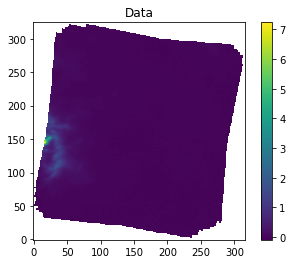

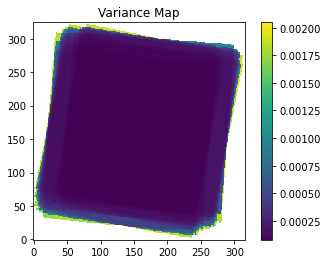

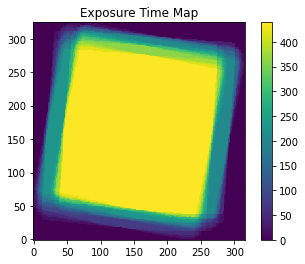

In [10]:
#take a quick look at the maps that were loaded in 
plt.figure()
plt.title('Data')
plt.imshow(data,origin='lower',interpolation='none')
plt.colorbar()
#plt.clim(0.0,0.1)
plt.show()

plt.figure()
plt.title('Variance Map')
plt.imshow(varmap,origin='lower',interpolation='none')
plt.colorbar()
plt.show()

plt.figure()
plt.title('Exposure Time Map')
plt.imshow(tmap,origin='lower',interpolation='none')
plt.colorbar()
plt.show()

#create pixel error map by taking sqrt of variance map
errormap=np.sqrt(varmap)

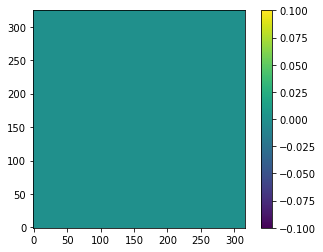

In [11]:
#create mask for edges of field where less integration time was collected
tmapnorm=tmap/np.max(tmap) #normalize the exposure time map
mask=np.where(tmapnorm<0.5,tmapnorm,0).astype('bool') #create mask for any locations with less than 50% of max exposure time -Can be modified as needed

#additional series of masks that can be applied when searching for sources in the segmentation map
mask2=np.zeros(np.shape(mask))  #mask 2 is applied to the first segmentation map instance for source detection
#mask2[0:300,280:314]=1
mask3=np.zeros(np.shape(mask))  #mask 3 is applied to the deblended segmentation map for source detection - this may or may not be needed if the first 2 masks work ok
#mask3[0:330,0:70]=1

#plot any of the masks to verify they are configured as needed
plt.figure()
plt.imshow(mask2,origin='lower',interpolation='none')
plt.colorbar()
plt.show()

In [12]:
#create background model for image using median method
bkg_estimator = MedianBackground()
bkg_data = Background2D(data,(20, 20), filter_size=(3, 3),bkg_estimator=bkg_estimator,edge_method='pad') #smaller box?, 20x20, 25x25?
bkg_rms=bkg_data.background_rms
bkg=bkg_data.background 

#create background subtracted image
data_bkgsub = data - bkg

#set detection threshold for source finding based on modeled background rms
threshold = 3.0*bkg_rms

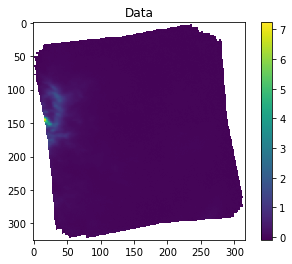

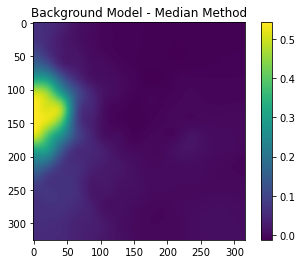

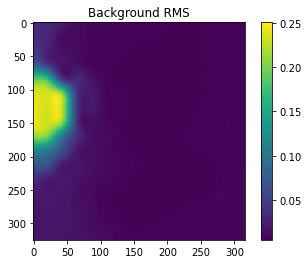

In [13]:
#take a look at data and bakground model images
plt.figure()
plt.title('Data')
plt.imshow(data,interpolation='none')
plt.colorbar()
plt.show()

plt.figure()
plt.title('Background Model - Median Method')
plt.imshow(bkg,interpolation='none')
plt.colorbar()
plt.show()

plt.figure()
plt.title('Background RMS')
plt.imshow(bkg_rms,interpolation='none')
plt.colorbar()
plt.show()

In [14]:
#do source detection. A 3x3 FWHM gaussian is used to smooth image prior to detection
sigma = 3.0 * gaussian_fwhm_to_sigma  # FWHM = 3.
kernel = Gaussian2DKernel(sigma, x_size=3, y_size=3)
kernel.normalize()
segm = detect_sources(data_bkgsub, threshold, mask=mask, npixels=5, filter_kernel=kernel)

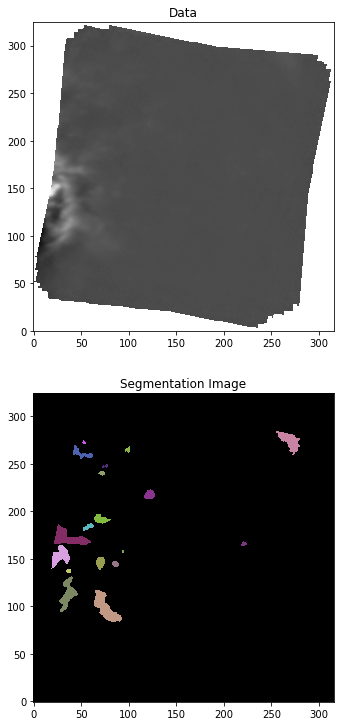

In [15]:
#removed labels that exist in masked region (mask2)
segm.remove_masked_labels(mask2.astype('bool'))

#make plot of segmentation image to show detected sources
norm = ImageNormalize(stretch=SqrtStretch())
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12.5))
ax1.imshow(data_bkgsub, origin='lower', cmap='Greys_r', norm=norm)
ax1.set_title('Data')
cmap = segm.make_cmap(seed=123)
ax2.imshow(segm, origin='lower', cmap=cmap, interpolation='nearest')
ax2.set_title('Segmentation Image')
plt.show()

In [16]:
#now lets look at building a catalog and associated table from the seg map
cat = SourceCatalog(data_bkgsub, segm,background=bkg,wcs=wcsmap) #can also take in error and bkg measurements - this is done later

#specify the columns that we want for our table
columns=['label','xcentroid','ycentroid','sky_centroid','background_centroid', 'background_mean','background_sum','area',
         'semimajor_sigma','semiminor_sigma','orientation', 'cxx','cxy','cyy','eccentricity','ellipticity','elongation',
         'fwhm','kron_flux','kron_fluxerr','kron_radius','segment_flux','segment_fluxerr']

#create table
tbl = cat.to_table(columns)

#display table below
tbl

label,xcentroid,ycentroid,sky_centroid,background_centroid,background_mean,background_sum,area,semimajor_sigma,semiminor_sigma,orientation,cxx,cxy,cyy,eccentricity,ellipticity,elongation,fwhm,kron_flux,kron_fluxerr,kron_radius,segment_flux,segment_fluxerr
,,,"deg,deg",,,,pix2,pix,pix,deg,1 / pix2,1 / pix2,1 / pix2,,,,pix,,,pix,,
int32,float64,float64,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
1,74.00461278534098,100.46144303946137,"266.40279240400434,-29.01828332025559",0.006243292811075321,0.06578844141727347,30.065317727693976,457.0,10.436126736517915,3.810691389844325,-57.06277337077351,0.05122005580325701,0.05446923483021929,0.026825637681182533,0.9309509634261804,0.6348557768554095,2.738643901820728,18.499514093191582,nan,nan,3.919455444549845,50.399432878872695,nan
2,35.9859784207421,112.68980400772426,"266.41206667459636,-29.015673006343825",-0.0047316795508389985,0.40120003875898513,125.17441209280337,312.0,8.857590161620028,3.367911190302502,75.45983819503478,0.08340797677760749,-0.036654643354320074,0.01749932699094705,0.9248924439317453,0.6197711647468547,2.6299951694463917,15.779027745654158,606.2053151059476,nan,2.044452860176453,286.2262621310965,nan
3,37.200720194988506,137.50039675385466,"266.4117689216286,-29.010380141501876",-0.008270975011997061,0.4893780088694921,8.808804159650858,18.0,1.2899318847222103,1.0468140356600746,1.3002268248765105,0.6011493167307105,-0.014136212988535504,0.9123985181955522,0.584315478766128,0.18847340075983288,1.2322454999457821,2.7661588516486924,129.23898048441436,nan,3.585954060834935,15.204486007203998,nan
4,69.86604834015083,146.34747550457223,"266.4038001829165,-29.008494157834978",-0.005788378821259641,0.07171077873684595,7.3144994311582865,102.0,3.116006018226051,2.275861435758936,79.95696894390255,0.1903278578561086,-0.030934622854125474,0.10573126757579561,0.6830434508984352,0.2696222592488481,1.369154540459512,6.4250432689216845,39.622881872678676,nan,3.1139779857178547,10.931522994433662,nan
5,26.39224419649729,151.63465986286744,"266.4144046588217,-29.00736426804606",-0.008024042335203475,0.4493135435399928,122.66259738641804,273.0,5.9744126038565115,3.7259873422502747,39.99235377117578,0.04619613337524456,-0.04334369436986331,0.0538507249734215,0.7816977030433441,0.3763424809586917,1.6034441491817635,11.724141237888338,nan,nan,nan,389.1956450657266,nan
6,86.05496472931497,144.45247931484053,"266.39985119181296,-29.00889893982136",-0.0023103554434617374,0.037300930546291536,1.2682316385739123,34.0,1.8215370784693252,1.4016482929997354,-27.467971447250093,0.34555823341440983,0.1699376290709403,0.4648332068476751,0.6386630099291726,0.2305134440757204,1.2995678641829367,3.8270771496114606,11.591377244916687,nan,3.342405667176134,2.077001690066549,nan
7,93.95793386951757,157.9812572452596,"266.39792298484195,-29.006013010646644",-0.007263825178034498,0.024277715667357605,0.21849944100621846,9.0,0.8148533677116487,0.7815397215976451,-43.04483348191314,1.567149452391935,0.13082439890804082,1.5760918686985002,0.28300984190752315,0.04088299494614389,1.0426256595709595,1.8800184414416212,2.7814735157401733,nan,3.4587627456635976,0.40669940008875227,nan
8,220.8729447195136,165.5584920189557,"266.36696491044415,-29.004396138874334",0.004189852998581704,0.0050491700167351735,0.12118008040164416,24.0,1.6532883585276017,1.0623838463097814,10.640271057097639,0.3835833448515603,-0.1887831104969417,0.8682732803854961,0.7662115936740014,0.357411645203909,1.5562062283517797,3.272277216277711,3.976249172081592,nan,3.340360732938038,0.7515682721855789,nan


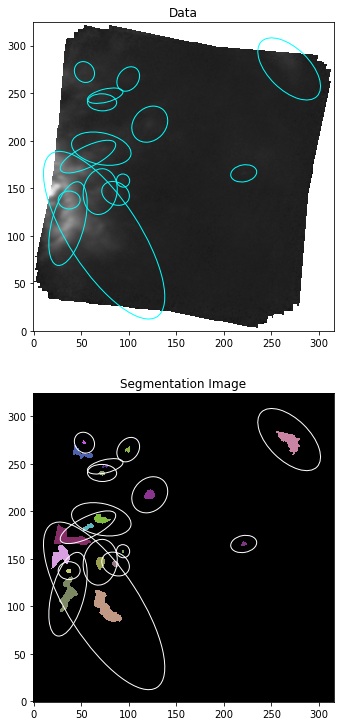

In [17]:
#overplot catalog sources on image - Note some sources may not have apertures plotted if kron aperture fails, but that's ok
norm = simple_norm(data, 'sqrt')
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12.5))
ax1.imshow(data, origin='lower', cmap='Greys_r', norm=norm)
ax1.set_title('Data')
cmap = segm.make_cmap(seed=123)
ax2.imshow(segm, origin='lower', cmap=cmap,interpolation='nearest')
ax2.set_title('Segmentation Image')
#try-except logic to catch any instances where kron aperture does something weird
for aperture in cat.kron_aperture:
    try:
        aperture.plot(axes=ax1, color='cyan', lw=1.)
        aperture.plot(axes=ax2, color='white', lw=1.)
    except:
        skip=1
plt.show()

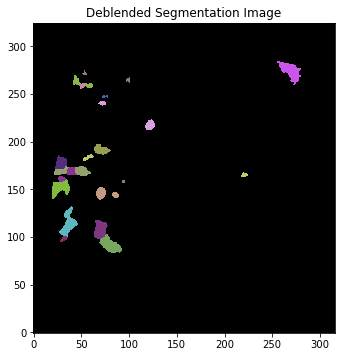

In [18]:
#lets take a look at deblending sources
segm_deblend = deblend_sources(data_bkgsub, segm, npixels=5,filter_kernel=kernel, nlevels=64,contrast=0.001)

#remove any sources that should be masked (mask3)
segm_deblend.remove_masked_labels(mask3.astype('bool'))

#plot the deblended image
plt.figure(figsize=(5.4, 8.5))
plt.imshow(segm_deblend, origin='lower', cmap=cmap, interpolation='nearest')
plt.title('Deblended Segmentation Image')
plt.show()

In [19]:
#now lets look at building a catalog and table from the deblended seg map
catde = SourceCatalog(data_bkgsub, segm_deblend,background=bkg,wcs=wcsmap)

#define which columns we want to have in the table
columns=['label','xcentroid','ycentroid','sky_centroid','background_centroid', 'background_mean','background_sum','area',
         'semimajor_sigma','semiminor_sigma','orientation', 'cxx','cxy','cyy','eccentricity','ellipticity','elongation',
         'fwhm','kron_flux','kron_fluxerr','kron_radius','segment_flux','segment_fluxerr']

#create table
tbl_deblend = catde.to_table(columns)

#display table
tbl_deblend

label,xcentroid,ycentroid,sky_centroid,background_centroid,background_mean,background_sum,area,semimajor_sigma,semiminor_sigma,orientation,cxx,cxy,cyy,eccentricity,ellipticity,elongation,fwhm,kron_flux,kron_fluxerr,kron_radius,segment_flux,segment_fluxerr
,,,"deg,deg",,,,pix2,pix,pix,deg,1 / pix2,1 / pix2,1 / pix2,,,,pix,,,pix,,
int32,float64,float64,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
1,37.200720194988506,137.50039675385466,"266.4117689216286,-29.010380141501876",-0.008270975011997061,0.4893780088694921,8.808804159650858,18.0,1.2899318847222103,1.0468140356600746,1.3002268248765105,0.6011493167307105,-0.014136212988535504,0.9123985181955522,0.584315478766128,0.18847340075983288,1.2322454999457821,2.7661588516486924,129.23898048441436,nan,3.585954060834935,15.204486007203998,nan
2,69.86604834015083,146.34747550457223,"266.4038001829165,-29.008494157834978",-0.005788378821259641,0.07171077873684595,7.3144994311582865,102.0,3.116006018226051,2.275861435758936,79.95696894390255,0.1903278578561086,-0.030934622854125474,0.10573126757579561,0.6830434508984352,0.2696222592488481,1.369154540459512,6.4250432689216845,39.622881872678676,nan,3.1139779857178547,10.931522994433662,nan
3,86.05496472931497,144.45247931484053,"266.39985119181296,-29.00889893982136",-0.0023103554434617374,0.037300930546291536,1.2682316385739123,34.0,1.8215370784693252,1.4016482929997354,-27.467971447250093,0.34555823341440983,0.1699376290709403,0.4648332068476751,0.6386630099291726,0.2305134440757204,1.2995678641829367,3.8270771496114606,11.591377244916687,nan,3.342405667176134,2.077001690066549,nan
4,93.95793386951757,157.9812572452596,"266.39792298484195,-29.006013010646644",-0.007263825178034498,0.024277715667357605,0.21849944100621846,9.0,0.8148533677116487,0.7815397215976451,-43.04483348191314,1.567149452391935,0.13082439890804082,1.5760918686985002,0.28300984190752315,0.04088299494614389,1.0426256595709595,1.8800184414416212,2.7814735157401733,nan,3.4587627456635976,0.40669940008875227,nan
5,220.8729447195136,165.5584920189557,"266.36696491044415,-29.004396138874334",0.004189852998581704,0.0050491700167351735,0.12118008040164416,24.0,1.6532883585276017,1.0623838463097814,10.640271057097639,0.3835833448515603,-0.1887831104969417,0.8682732803854961,0.7662115936740014,0.357411645203909,1.5562062283517797,3.272277216277711,3.976249172081592,nan,3.340360732938038,0.7515682721855789,nan
6,56.99995003255465,183.17910709724458,"266.4069369506023,-29.000636251131553",-0.009232917551823436,0.09860725097649098,4.930362548824549,50.0,3.477963482908291,1.1889173938164965,26.06247938838124,0.20327143435615366,-0.49317192951502004,0.5868503970856133,0.9397570848370407,0.6581570221598998,2.9253197076575845,6.120211853120864,69.7037719114044,nan,3.6895858950394667,6.657713640335798,nan
7,71.02853255338101,191.52501045638067,"266.40351480742385,-28.99885632511144",-0.010759750482165828,0.05288734895953914,6.346481875144697,120.0,4.268924013585962,2.228355428372471,-11.999934421964822,0.06120686255674313,0.059592009981828925,0.19505353298040673,0.8529487686814909,0.4780053659234337,1.9157285050813755,8.018374936218462,32.38145441304831,nan,2.9798789287891805,8.466118350065493,nan
8,122.01079890459769,217.31808233211413,"266.39107921078124,-28.993355011417908",-0.0008386122463463912,0.022075276663136044,1.9646996230191078,89.0,2.7126959971994338,2.223501070831285,45.88553785183448,0.17010585101210207,-0.06634221668681188,0.1680544865645911,0.5728436329937886,0.18033532945571118,1.2200111044629525,5.840399160461196,15.049364550147097,nan,3.0560279968280915,4.185130953013292,nan


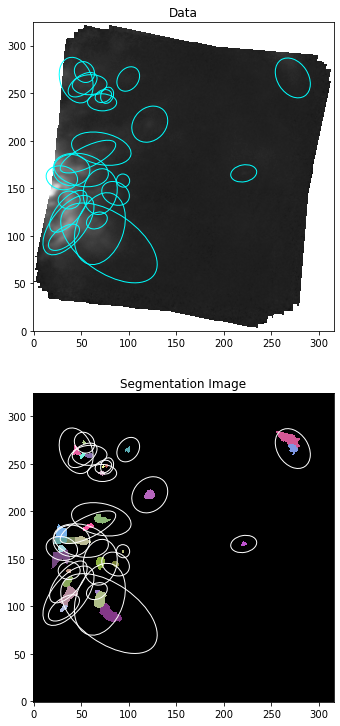

In [20]:
#overplot catalog sources on image - Note some sources may not have apertures plotted if kron aperture fails, but that's ok
norm = simple_norm(data, 'sqrt')
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12.5))
ax1.imshow(data, origin='lower', cmap='Greys_r', norm=norm)
ax1.set_title('Data')
cmap = segm_deblend.make_cmap(seed=123)
ax2.imshow(segm_deblend, origin='lower', cmap=cmap,interpolation='nearest')
ax2.set_title('Segmentation Image')
#try-except logic to catch any instances where kron aperture does something weird
for aperture in catde.kron_aperture:
    try:
        aperture.plot(axes=ax1, color='cyan', lw=1.)
        aperture.plot(axes=ax2, color='white', lw=1.)
    except:
        skip=1
plt.show()

In [21]:
#what if we wanted to include errors? - Not completely sure this is implemented correctly for our observations, but we'll use it for now...
calfactor = header['CALFCTR'] # units are (Me/sec/Jy)
gainfactor=tmap*calfactor*1e6 #gain in electrons/Jy
#errormap=calc_total_error(data,bkg,gainfactor) #use the varmap instead. Its probably more appropriate for our data type. 

#now lets look at building a catalog from the seg map
catwerr = SourceCatalog(data_bkgsub, segm_deblend,background=bkg,error=errormap,wcs=wcsmap)
columns=['label','xcentroid','ycentroid','sky_centroid','background_centroid', 'background_mean','background_sum','background','area',
         'semimajor_sigma','semiminor_sigma','orientation', 'cxx','cxy','cyy','eccentricity','ellipticity','elongation',
         'fwhm','kron_flux','kron_fluxerr','kron_radius','segment_flux','segment_fluxerr']#,'kron_aperture']
tbl2 = catwerr.to_table(columns)

In [22]:
#calculate statistics for background cutouts in table
segbkg_median=[]
segbkg_mean=[]
segbkg_std=[]

#loop through each cutout and use sigma_cliped_stats to get mean, median, and std
for i in range (0,len(tbl2['background'])):
    bkgdata=tbl2['background'][i]
    meansc, median_sigclip, stdsc = sigma_clipped_stats(bkgdata)
    segbkg_median.append(median_sigclip)
    segbkg_mean.append(meansc)
    segbkg_std.append(stdsc)

#add the above calculated information to our table
tbl2['segbkg_mean_sc']=segbkg_mean
tbl2['segbkg_median_sc']=segbkg_median
tbl2['segbkg_std_sc']=segbkg_std  

#remove the 2d background array to tidy up the table
tbl2.remove_column('background')

In [23]:
#calculate noise stats
#sky noise from background
skynoise=np.sqrt(tbl2['segbkg_median_sc']*tbl2['area']/u.pix**2)
#replace any nan values with zero
sna=np.array(skynoise)
masknan=np.isnan(sna)
sna[masknan]=0.0
skynoise=sna**2

#shot noise from the source
sourcenoise=tbl2['segment_flux']

#thermal noise from camera (from error map)
thermalnoise=tbl2['segment_fluxerr']

#total noise
#totalnoise=np.sqrt(sourcenoise+thermalnoise+skynoise) #includes all noise sources
totalnoise=np.sqrt(thermalnoise+skynoise) #no shot noise -> For some reason this seems to work much better for the apertures. Need to think about why this is a bit more...

#calculate SNR for the segments
tbl2['segmentSNR']=tbl2['segment_flux']/ totalnoise 

#display table
tbl2

label,xcentroid,ycentroid,sky_centroid,background_centroid,background_mean,background_sum,area,semimajor_sigma,semiminor_sigma,orientation,cxx,cxy,cyy,eccentricity,ellipticity,elongation,fwhm,kron_flux,kron_fluxerr,kron_radius,segment_flux,segment_fluxerr,segbkg_mean_sc,segbkg_median_sc,segbkg_std_sc,segmentSNR
,,,"deg,deg",,,,pix2,pix,pix,deg,1 / pix2,1 / pix2,1 / pix2,,,,pix,,,pix,,,,,,
int32,float64,float64,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float64,float64,float64,float64
1,37.200720194988506,137.50039675385466,"266.4117689216286,-29.010380141501876",-0.008270975011997061,0.4893780088694921,8.808804159650858,18.0,1.2899318847222103,1.0468140356600746,1.3002268248765105,0.6011493167307105,-0.014136212988535504,0.9123985181955522,0.584315478766128,0.18847340075983288,1.2322454999457821,2.7661588516486924,129.23898048441436,0.2196870479691528,3.585954060834935,15.204486007203998,0.053877138,0.49060345475717915,0.4912236040141279,0.009231972123030906,5.097729044545326
2,69.86604834015083,146.34747550457223,"266.4038001829165,-29.008494157834978",-0.005788378821259641,0.07171077873684595,7.3144994311582865,102.0,3.116006018226051,2.275861435758936,79.95696894390255,0.1903278578561086,-0.030934622854125474,0.10573126757579561,0.6830434508984352,0.2696222592488481,1.369154540459512,6.4250432689216845,39.622881872678676,0.33666831761299004,3.1139779857178547,10.931522994433662,0.09248137,0.07194021592505818,0.07052467841130808,0.014126321039098137,4.04982383402741
3,86.05496472931497,144.45247931484053,"266.39985119181296,-29.00889893982136",-0.0023103554434617374,0.037300930546291536,1.2682316385739123,34.0,1.8215370784693252,1.4016482929997354,-27.467971447250093,0.34555823341440983,0.1699376290709403,0.4648332068476751,0.6386630099291726,0.2305134440757204,1.2995678641829367,3.8270771496114606,11.591377244916687,0.21655351689908797,3.342405667176134,2.077001690066549,0.053269394,0.03726409687939056,0.03740235273935029,0.0024969042188686106,1.8044182281109467
4,93.95793386951757,157.9812572452596,"266.39792298484195,-29.006013010646644",-0.007263825178034498,0.024277715667357605,0.21849944100621846,9.0,0.8148533677116487,0.7815397215976451,-43.04483348191314,1.567149452391935,0.13082439890804082,1.5760918686985002,0.28300984190752315,0.04088299494614389,1.0426256595709595,1.8800184414416212,2.7814735157401733,0.11142945343161474,3.4587627456635976,0.40669940008875227,0.027315618,0.024277715667357605,0.024253564564579624,0.0015256989464862219,0.8206564448879864
5,220.8729447195136,165.5584920189557,"266.36696491044415,-29.004396138874334",0.004189852998581704,0.0050491700167351735,0.12118008040164416,24.0,1.6532883585276017,1.0623838463097814,10.640271057097639,0.3835833448515603,-0.1887831104969417,0.8682732803854961,0.7662115936740014,0.357411645203909,1.5562062283517797,3.272277216277711,3.976249172081592,0.1825208834858952,3.340360732938038,0.7515682721855789,0.045662634,0.005349336656664229,0.005322047276472766,0.0017336978944417789,1.8049043827347169
6,56.99995003255465,183.17910709724458,"266.4069369506023,-29.000636251131553",-0.009232917551823436,0.09860725097649098,4.930362548824549,50.0,3.477963482908291,1.1889173938164965,26.06247938838124,0.20327143435615366,-0.49317192951502004,0.5868503970856133,0.9397570848370407,0.6581570221598998,2.9253197076575845,6.120211853120864,69.7037719114044,0.32089322262358744,3.6895858950394667,6.657713640335798,0.06427526,0.09796641507492582,0.09649879921470865,0.015943555123033786,3.0109637993196254
7,71.02853255338101,191.52501045638067,"266.40351480742385,-28.99885632511144",-0.010759750482165828,0.05288734895953914,6.346481875144697,120.0,4.268924013585962,2.228355428372471,-11.999934421964822,0.06120686255674313,0.059592009981828925,0.19505353298040673,0.8529487686814909,0.4780053659234337,1.9157285050813755,8.018374936218462,32.38145441304831,0.393165699908

In [24]:
#now lets look at performing some aperture photometry on the data.... Lets get the source centroids from the segmentaion map table
sourcecoords=tbl2['sky_centroid']

In [25]:
#first let's do some simple annulus extractions...   
radii = [2,4,6,8,10] #define aperture radii & construct apertures (line below)
apertures =[SkyCircularAperture(sourcecoords, r=r*u.arcsec) for r in radii] # for pixels: r=r*u.arcsec*0.786

#do aperture photometry on data using defined apertures 
phot_table = aperture_photometry(data_bkgsub, apertures,wcs=wcsmap,error=errormap,method='exact')

#display phot table
phot_table

id,xcenter,ycenter,sky_center,aperture_sum_0,aperture_sum_err_0,aperture_sum_1,aperture_sum_err_1,aperture_sum_2,aperture_sum_err_2,aperture_sum_3,aperture_sum_err_3,aperture_sum_4,aperture_sum_err_4
,pix,pix,"deg,deg",,,,,,,,,,
int32,float64,float64,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
1,37.20072019496443,137.50039675382095,"266.4117689216286,-29.010380141501876",17.46690539358323,0.05860826587579867,54.6675971158247,0.11672790841541635,101.29151478781043,0.17290546063958653,154.1554131160242,0.22638762919108651,214.70653969412075,0.2783440380479851
2,69.86604834017292,146.3474755045523,"266.4038001829165,-29.008494157834978",3.091822764064164,0.042260457755021665,9.886303337785863,0.08451428953787667,16.58051204217258,0.1268215770983859,22.397877768607373,0.1691275753590517,27.51737229914807,0.21142651846397006
3,86.05496472938653,144.45247931481995,"266.39985119181296,-29.00889893982136",1.352835814320522,0.0421626541596182,3.95368325883226,0.08438386523192397,6.275647561654695,0.1266617137677662,8.884725447015299,0.1689609259797464,12.327058413616701,0.21124725382151907
4,93.95793386943853,157.98125724525303,"266.39792298484195,-29.006013010646644",0.826707621402687,0.04202987030132058,2.1396329822504034,0.08410238362216707,3.095143912762773,0.12616534396634654,4.046679360099558,0.16827002588586495,5.225470676946398,0.21034543772340855
5,220.87294471949468,165.55849201897564,"266.36696491044415,-29.004396138874334",0.6487466406877496,0.043021715347067696,1.575811939995172,0.0859756155474563,2.6358353628578604,0.12888561527209194,3.5652069374206192,0.17176581764326737,4.5507434560464795,0.21464115755150082
6,56.99995003250045,183.17910709723824,"266.4069369506023,-29.000636251131553",2.7819886735669086,0.04196284018145809,10.135708633500048,0.0838850762664347,18.66192102890534,0.12697505855920707,28.15890889689318,0.1753608436506524,41.137508452725925,0.2255005329383797
7,71.02853255321713,191.5250104563703,"266.40351480742385,-28.99885632511144",1.7141402678578,0.04221628761229616,6.006864736915489,0.08441786131223429,11.525744793525725,0.12662794270266942,17.482318069830452,0.16881698083250174,23.702292374225344,0.2110187790282771
8,122.01079890453177,217.31808233217012,"266.39107921078124,-28.993355011417908",1.4037368241618933,0.0426081880862668,4.038446759827651,0.08517961978661288,6.406873924566096,0.12771977995678918,8.491461650298454,0.17023781196038767,10.467673450583348,0.21271550899949743


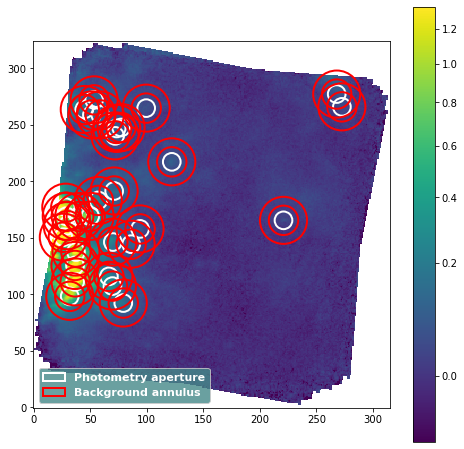

In [26]:
#now try photometry with local background subtraction
aperture2 =SkyCircularAperture(sourcecoords, r=6*u.arcsec) #define aperture
annulus_aperture = SkyCircularAnnulus(sourcecoords, r_in=10*u.arcsec, r_out=16*u.arcsec) #define annulus

#convert to pixel coords for plotting
pix_aperture = aperture2.to_pixel(wcsmap)
pix_annulus_aperture = annulus_aperture.to_pixel(wcsmap)


#show figure with apertures overlayed
plt.figure(figsize=(8,8))
norm = simple_norm(data, 'sqrt', percent=99)
plt.imshow(data, norm=norm, interpolation='nearest',origin='lower')
plt.colorbar()
#plt.xlim(40, 140)
#plt.ylim(50, 125)

ap_patches = pix_aperture.plot(color='white', lw=2,
                           label='Photometry aperture')
ann_patches = pix_annulus_aperture.plot(color='red', lw=2,
                                    label='Background annulus')
handles = (ap_patches[0], ann_patches[0])
plt.legend(loc='best', facecolor='#458989', labelcolor='white',
           handles=handles, prop={'weight': 'bold', 'size': 11})
plt.show()

In [27]:
#now lets do robust statistics on the background annuli

#create lists to store information for later
bkg_median=[]
bkg_mean=[]
bkg_std=[]
appmasks=[]

#create mask array for the annuli
annulus_masks = pix_annulus_aperture.to_mask(method='exact')

#for each of the annuli loop through and calculate stats using sigma cliped stats
for mask in annulus_masks:
    annulus_data = mask.multiply(data_bkgsub)
    
    #this is a bit of debugging to handle if the mask array is the wrong shape
    if np.shape(mask.data)[0]==41:
        maskdata=mask.data[:-1,:]
    else:
        maskdata=mask.data
        
    #do statistics
    annulus_data_1d = annulus_data[maskdata > 0]
    meansc, median_sigclip, stdsc = sigma_clipped_stats(annulus_data_1d)
    bkg_median.append(median_sigclip)
    bkg_mean.append(meansc)
    bkg_std.append(stdsc)
    appmasks.append(mask.data)

#store values in numpy arrays
bkg_median = np.array(bkg_median)
bkg_mean = np.array(bkg_mean)
bkg_std = np.array(bkg_std)

In [28]:
#do aperture photometry
phot_table2 = aperture_photometry(data_bkgsub, aperture2,wcs=wcsmap,error=errormap,method='exact') #

#add columns for background information and also background subtracted apertures
phot_table2['ann_bkg_med'] = bkg_median
phot_table2['ann_bkg_mean'] = bkg_mean 
phot_table2['aper_sum_bkgsub_6as'] = (phot_table2['aperture_sum']/pix_aperture.area - phot_table2['ann_bkg_med'])* pix_aperture.area 
phot_table2['aper_sum_bkgsub_err_6as'] = phot_table2['aperture_sum_err'] # should this be modified by bkgsub in some way?
#not sure if the above is right for the error array...

#calculate sky noise for 6 pixel aperture
skynoise=np.sqrt(phot_table2['ann_bkg_med']*pix_aperture.area)
sna=np.array(skynoise)
masknan=np.isnan(sna)
sna[masknan]=0.0
skynoise=sna**2

#store per pix sky noise for later
phot_table2['skynoise_pix']=skynoise/pix_aperture.area

#shot noise from the source
sourcenoise=phot_table2['aper_sum_bkgsub_6as']

#thermal noise from camera (from error map)
thermalnoise=phot_table2['aperture_sum_err']

#compute total noise 
#totalnoise=np.sqrt(sourcenoise+thermalnoise+skynoise) #all noise sources
#totalnoise=np.sqrt(thermalnoise+skynoise) # no shot noise -> For some reason this seems to give more 'reasonable' values. Need to think about why this is a bit more...
totalnoise=np.sqrt((thermalnoise+skynoise)*(1+pix_aperture.area/pix_annulus_aperture.area)) #modified to account for pixel stats

#SNR calc for 6 pixel aperture
phot_table2['aper_snr_6as']=phot_table2['aper_sum_bkgsub_6as']/totalnoise

#display new table
phot_table2

<ipython-input-28-d3b3f743c6c3>:12: RuntimeWarning: invalid value encountered in sqrt
  skynoise=np.sqrt(phot_table2['ann_bkg_med']*pix_aperture.area)


id,xcenter,ycenter,sky_center,aperture_sum,aperture_sum_err,ann_bkg_med,ann_bkg_mean,aper_sum_bkgsub_6as,aper_sum_bkgsub_err_6as,skynoise_pix,aper_snr_6as
,pix,pix,"deg,deg",,,,,,,,
int32,float64,float64,object,float64,float64,float64,float64,float64,float64,float64,float64
1,37.20072019496443,137.50039675382095,"266.4117689216286,-29.010380141501876",101.29151478781043,0.17290546063958653,0.07387915834630654,0.22645202973143064,87.12536384199457,0.17290546063958653,0.07387915834630654,20.73939117008405
2,69.86604834017292,146.3474755045523,"266.4038001829165,-29.008494157834978",16.58051204217258,0.1268215770983859,0.017199612363709427,0.016354323363855963,13.282527733638434,0.1268215770983859,0.017199612363709427,6.469555391908143
3,86.05496472938653,144.45247931481995,"266.39985119181296,-29.00889893982136",6.275647561654695,0.1266617137677662,0.003933244249886969,0.008630354718447605,5.521457435537123,0.1266617137677662,0.003933244249886969,5.302906630888053
4,93.95793386943853,157.98125724525303,"266.39792298484195,-29.006013010646644",3.095143912762773,0.12616534396634654,0.0018229250310495596,0.003823440584477421,2.7456024218905353,0.12616534396634654,0.0018229250310495598,3.588224758167444
5,220.87294471949468,165.55849201897564,"266.36696491044415,-29.004396138874334",2.6358353628578604,0.12888561527209194,0.0023565094196662862,0.003284930035441781,2.1839803486500755,0.12888561527209194,0.0023565094196662867,2.5832670567474816
6,56.99995003250045,183.17910709723824,"266.4069369506023,-29.000636251131553",18.66192102890534,0.12697505855920707,0.017337863163001732,0.02759676468940889,15.337427462077073,0.12697505855920707,0.017337863163001732,7.441530080611946
7,71.02853255321713,191.5250104563703,"266.40351480742385,-28.99885632511144",11.525744793525725,0.12662794270266942,0.006025195253190406,0.008237657856187488,10.370428093318953,0.12662794270266942,0.006025195253190405,8.256076975244206
8,122.01079890453177,217.31808233217012,"266.39107921078124,-28.993355011417908",6.406873924566096,0.12771977995678918,0.004608799525321072,0.005470470800597671,5.5231476989821155,0.12771977995678918,0.004608799525321071,4.950248378968689


In [29]:
#fix id keyword in tbl2 so these can be merged with the phot table results
try:
    tbl2.rename_column('label', 'id')
except:
    print('Do nothing because keyword is already changed.')

In [30]:
#merge the two photometry tables
merged_table = join(phot_table, phot_table2, keys='id')

#merge the segmentation map table with the combined phot table
merged_table_2 = join(tbl2,merged_table, keys='id')

#drop repeat columns
merged_table_2.remove_columns(['xcenter_1','ycenter_1','xcenter_2','ycenter_2','sky_center_1','sky_center_2','aperture_sum','aperture_sum_err'])

#rename some columns to avoid possible confusion
merged_table_2.rename_column('aperture_sum_0', 'aperture_sum_2as')
merged_table_2.rename_column('aperture_sum_err_0', 'aperture_sum_err_2as')
merged_table_2.rename_column('aperture_sum_1', 'aperture_sum_4as')
merged_table_2.rename_column('aperture_sum_err_1', 'aperture_sum_err_4as')
merged_table_2.rename_column('aperture_sum_2', 'aperture_sum_6as')
merged_table_2.rename_column('aperture_sum_err_2', 'aperture_sum_err_6as')
merged_table_2.rename_column('aperture_sum_3', 'aperture_sum_8as')
merged_table_2.rename_column('aperture_sum_err_3', 'aperture_sum_err_8as')
merged_table_2.rename_column('aperture_sum_4', 'aperture_sum_10as')
merged_table_2.rename_column('aperture_sum_err_4', 'aperture_sum_err_10as')


#compute area for the different size apertures 
ap2area=pix_aperture.area*(2./6.)**2
ap4area=pix_aperture.area*(4./6.)**2
#ap6area=pix_aperture.area*(6./6.)**2
ap8area=pix_aperture.area*(8./6.)**2
ap10area=pix_aperture.area*(10./6.)**2


#calculate local bkg subtracted photometry for the other apertures 
merged_table_2['aper_sum_bkgsub_2as']=(merged_table_2['aperture_sum_2as']/ap2area-merged_table_2['ann_bkg_med'])*ap2area
merged_table_2['aper_sum_bkgsub_4as']=(merged_table_2['aperture_sum_4as']/ap4area-merged_table_2['ann_bkg_med'])*ap4area
#merged_table_2['aper_sum_bkgsub_6as']=(merged_table_2['aperture_sum_6as']/ap6area-merged_table_2['ann_bkg_med'])*ap6area
merged_table_2['aper_sum_bkgsub_8as']=(merged_table_2['aperture_sum_8as']/ap8area-merged_table_2['ann_bkg_med'])*ap8area
merged_table_2['aper_sum_bkgsub_10as']=(merged_table_2['aperture_sum_10as']/ap10area-merged_table_2['ann_bkg_med'])*ap10area

#calculate snr for each aperture
merged_table_2['aper_snr_2as']=merged_table_2['aper_sum_bkgsub_2as']/np.sqrt((merged_table_2['aperture_sum_err_2as']+merged_table_2['skynoise_pix']*ap2area)*(1+ap2area/pix_annulus_aperture.area))
merged_table_2['aper_snr_4as']=merged_table_2['aper_sum_bkgsub_4as']/np.sqrt((merged_table_2['aperture_sum_err_4as']+merged_table_2['skynoise_pix']*ap4area)*(1+ap4area/pix_annulus_aperture.area))
#merged_table_2['aper_snr_6as']=merged_table_2['aper_sum_bkgsub_6as']/np.sqrt((merged_table_2['aperture_sum_err_6as']+merged_table_2['skynoise_pix']*ap6area)*(1+ap6area/pix_annulus_aperture.area))
merged_table_2['aper_snr_8as']=merged_table_2['aper_sum_bkgsub_8as']/np.sqrt((merged_table_2['aperture_sum_err_8as']+merged_table_2['skynoise_pix']*ap8area)*(1+ap8area/pix_annulus_aperture.area))
merged_table_2['aper_snr_10as']=merged_table_2['aper_sum_bkgsub_10as']/np.sqrt((merged_table_2['aperture_sum_err_10as']+merged_table_2['skynoise_pix']*ap10area)*(1+ap10area/pix_annulus_aperture.area))

#calculate max snr for all apertures
snr_values=np.array(merged_table_2['aper_snr_2as','aper_snr_4as','aper_snr_6as','aper_snr_8as','aper_snr_10as'])
snr_values.dtype=np.float
snr_values=np.reshape(snr_values, (-1,5))
maxsnr=np.nanmax(snr_values,axis=1)
merged_table_2['aper_snr_max']=maxsnr

#add additonal information for wavelength and which field 
merged_table_2['Field']='C7'+field
merged_table_2['wv']=wavelength

#display table
merged_table_2

id,xcentroid,ycentroid,sky_centroid,background_centroid,background_mean,background_sum,area,semimajor_sigma,semiminor_sigma,orientation,cxx,cxy,cyy,eccentricity,ellipticity,elongation,fwhm,kron_flux,kron_fluxerr,kron_radius,segment_flux,segment_fluxerr,segbkg_mean_sc,segbkg_median_sc,segbkg_std_sc,segmentSNR,aperture_sum_2as,aperture_sum_err_2as,aperture_sum_4as,aperture_sum_err_4as,aperture_sum_6as,aperture_sum_err_6as,aperture_sum_8as,aperture_sum_err_8as,aperture_sum_10as,aperture_sum_err_10as,ann_bkg_med,ann_bkg_mean,aper_sum_bkgsub_6as,aper_sum_bkgsub_err_6as,skynoise_pix,aper_snr_6as,aper_sum_bkgsub_2as,aper_sum_bkgsub_4as,aper_sum_bkgsub_8as,aper_sum_bkgsub_10as,aper_snr_2as,aper_snr_4as,aper_snr_8as,aper_snr_10as,aper_snr_max,Field,wv
,,,"deg,deg",,,,pix2,pix,pix,deg,1 / pix2,1 / pix2,1 / pix2,,,,pix,,,pix,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
int32,float64,float64,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str8,float64
1,37.200720194988506,137.50039675385466,"266.4117689216286,-29.010380141501876",-0.008270975011997061,0.4893780088694921,8.808804159650858,18.0,1.2899318847222103,1.0468140356600746,1.3002268248765105,0.6011493167307105,-0.014136212988535504,0.9123985181955522,0.584315478766128,0.18847340075983288,1.2322454999457821,2.7661588516486924,129.23898048441436,0.2196870479691528,3.585954060834935,15.204486007203998,0.053877138,0.49060345475717915,0.4912236040141279,0.009231972123030906,5.097729044545326,17.46690539358323,0.05860826587579867,54.6675971158247,0.11672790841541635,101.29151478781043,0.17290546063958653,154.1554131160242,0.22638762919108651,214.70653969412075,0.2783440380479851,0.07387915834630654,0.22645202973143064,87.12536384199457,0.17290546063958653,0.07387915834630654,20.73939117008405,15.892888621825913,48.371530028795426,128.97114476790713,175.35612040018785,12.281797186622985,18.19132035962361,21.5444581154855,21.744928557729825,21.744928557729825,C7FieldC,25.2
2,69.86604834015083,146.34747550457223,"266.4038001829165,-29.008494157834978",-0.005788378821259641,0.07171077873684595,7.3144994311582865,102.0,3.116006018226051,2.275861435758936,79.95696894390255,0.1903278578561086,-0.030934622854125474,0.10573126757579561,0.6830434508984352,0.2696222592488481,1.369154540459512,6.4250432689216845,39.622881872678676,0.33666831761299004,3.1139779857178547,10.931522994433662,0.09248137,0.07194021592505818,0.07052467841130808,0.014126321039098137,4.04982383402741,3.091822764064164,0.042260457755021665,9.886303337785863,0.08451428953787667,16.58051204217258,0.1268215770983859,22.397877768607373,0.1691275753590517,27.51737229914807,0.21142651846397006,0.017199612363709427,0.016354323363855963,13.282527733638434,0.1268215770983859,0.017199612363709427,6.469555391908143,2.7253800631159257,8.42053253399291,16.53479455343556,18.356304775442112,4.209450291133678,6.440681871572293,5.669065923906376,4.680583419230098,6.469555391908143,C7FieldC,25.2
3,86.05496472931497,144.45247931484053,"266.39985119181296,-29.00889893982136",-0.0023103554434617374,0.037300930546291536,1.2682316385739123,34.0,1.8215370784693252,1.4016482929997354,-27.467971447250093,0.34555823341440983,0.1699376290709403,0.4648332068476751,0.6386630099291726,0.2305134440757204,1.2995678641829367,3.8270771496114606,11.591377244916687,0.21655351689908797,3.342405667176134,2.077001690066549,0.053269394,0.03726409687939056,0.03740235273935029,0.0024969042188686106,1.8044182281109467,1.352835814320522,0.0421626541596182,3.95368325883226,0.08438386523192397,6.275647561654695,0.1266617137677662,8.884725447015299,0.1689609259797464,12.327058413616701,0.21124725382151907,0.003933244249886969,0.008630354718447605,5

In [31]:
#write out the resulting table to file
ascii.write(merged_table_2, field+'_25um_cat.dat', overwrite=True)

In [32]:
#add simple quality cuts to saved sources
snrcut=merged_table_2['aper_snr_max']>=3.0 #max snr in all computed apertures must be gtreq to 3.0
fwhmcut=merged_table_2['fwhm']>=2.5*u.pix #fwhm measures must be greater than 2.5 pixels (~1.9")
keepconditions=(snrcut&fwhmcut) #conditions to keep a source
mtcut=merged_table_2[keepconditions] #apply conditions

#display new table with simple quality cuts
mtcut

id,xcentroid,ycentroid,sky_centroid,background_centroid,background_mean,background_sum,area,semimajor_sigma,semiminor_sigma,orientation,cxx,cxy,cyy,eccentricity,ellipticity,elongation,fwhm,kron_flux,kron_fluxerr,kron_radius,segment_flux,segment_fluxerr,segbkg_mean_sc,segbkg_median_sc,segbkg_std_sc,segmentSNR,aperture_sum_2as,aperture_sum_err_2as,aperture_sum_4as,aperture_sum_err_4as,aperture_sum_6as,aperture_sum_err_6as,aperture_sum_8as,aperture_sum_err_8as,aperture_sum_10as,aperture_sum_err_10as,ann_bkg_med,ann_bkg_mean,aper_sum_bkgsub_6as,aper_sum_bkgsub_err_6as,skynoise_pix,aper_snr_6as,aper_sum_bkgsub_2as,aper_sum_bkgsub_4as,aper_sum_bkgsub_8as,aper_sum_bkgsub_10as,aper_snr_2as,aper_snr_4as,aper_snr_8as,aper_snr_10as,aper_snr_max,Field,wv
,,,"deg,deg",,,,pix2,pix,pix,deg,1 / pix2,1 / pix2,1 / pix2,,,,pix,,,pix,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
int32,float64,float64,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str8,float64
1,37.200720194988506,137.50039675385466,"266.4117689216286,-29.010380141501876",-0.008270975011997061,0.4893780088694921,8.808804159650858,18.0,1.2899318847222103,1.0468140356600746,1.3002268248765105,0.6011493167307105,-0.014136212988535504,0.9123985181955522,0.584315478766128,0.18847340075983288,1.2322454999457821,2.7661588516486924,129.23898048441436,0.2196870479691528,3.585954060834935,15.204486007203998,0.053877138,0.49060345475717915,0.4912236040141279,0.009231972123030906,5.097729044545326,17.46690539358323,0.05860826587579867,54.6675971158247,0.11672790841541635,101.29151478781043,0.17290546063958653,154.1554131160242,0.22638762919108651,214.70653969412075,0.2783440380479851,0.07387915834630654,0.22645202973143064,87.12536384199457,0.17290546063958653,0.07387915834630654,20.73939117008405,15.892888621825913,48.371530028795426,128.97114476790713,175.35612040018785,12.281797186622985,18.19132035962361,21.5444581154855,21.744928557729825,21.744928557729825,C7FieldC,25.2
2,69.86604834015083,146.34747550457223,"266.4038001829165,-29.008494157834978",-0.005788378821259641,0.07171077873684595,7.3144994311582865,102.0,3.116006018226051,2.275861435758936,79.95696894390255,0.1903278578561086,-0.030934622854125474,0.10573126757579561,0.6830434508984352,0.2696222592488481,1.369154540459512,6.4250432689216845,39.622881872678676,0.33666831761299004,3.1139779857178547,10.931522994433662,0.09248137,0.07194021592505818,0.07052467841130808,0.014126321039098137,4.04982383402741,3.091822764064164,0.042260457755021665,9.886303337785863,0.08451428953787667,16.58051204217258,0.1268215770983859,22.397877768607373,0.1691275753590517,27.51737229914807,0.21142651846397006,0.017199612363709427,0.016354323363855963,13.282527733638434,0.1268215770983859,0.017199612363709427,6.469555391908143,2.7253800631159257,8.42053253399291,16.53479455343556,18.356304775442112,4.209450291133678,6.440681871572293,5.669065923906376,4.680583419230098,6.469555391908143,C7FieldC,25.2
3,86.05496472931497,144.45247931484053,"266.39985119181296,-29.00889893982136",-0.0023103554434617374,0.037300930546291536,1.2682316385739123,34.0,1.8215370784693252,1.4016482929997354,-27.467971447250093,0.34555823341440983,0.1699376290709403,0.4648332068476751,0.6386630099291726,0.2305134440757204,1.2995678641829367,3.8270771496114606,11.591377244916687,0.21655351689908797,3.342405667176134,2.077001690066549,0.053269394,0.03726409687939056,0.03740235273935029,0.0024969042188686106,1.8044182281109467,1.352835814320522,0.0421626541596182,3.95368325883226,0.08438386523192397,6.275647561654695,0.1266617137677662,8.884725447015299,0.1689609259797464,12.327058413616701,0.21124725382151907,0.003933244249886969,0.008630354718447605,5

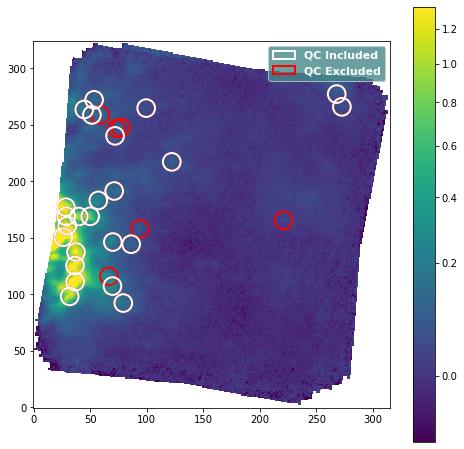

In [33]:
#now let's examine which sources didn't pass the cuts - overplot on the image to see if it looks first order reasonable

#get source coordinates for the snr cut table
cutsc=mtcut['sky_centroid'] 

#Compare which sources are included/excluded
source_aperture =SkyCircularAperture(cutsc, r=6*u.arcsec)

#convert to pixel coords for plotting
pix_aperture_source = source_aperture.to_pixel(wcsmap)


#show figure with apertures overlayed
plt.figure(figsize=(8,8))
norm = simple_norm(data, 'sqrt', percent=99)
plt.imshow(data, norm=norm, interpolation='nearest',origin='lower')
plt.colorbar()
#plt.xlim(40, 140)
#plt.ylim(50, 125)


ap_patches = pix_aperture.plot(color='red', lw=2,
                           label='QC Excluded')
ap_patches_new = pix_aperture_source.plot(color='white', lw=2,
                           label='QC Included')

handles = (ap_patches_new[0],ap_patches[0])
plt.legend(loc='best', facecolor='#458989', labelcolor='white',
          handles=handles, prop={'weight': 'bold', 'size': 11})
plt.show()

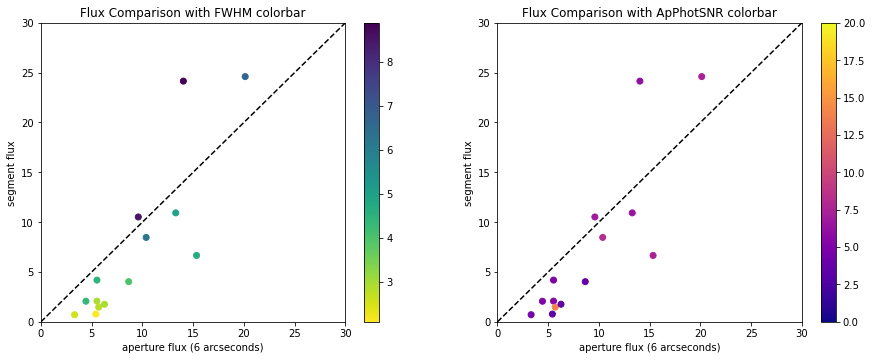

In [34]:
#a few diagnostic plots to examine segment and aperture fluxes
fig, (ax1,ax2) = plt.subplots(1, 2,figsize=(15,5.5))

ax1.set_title('Flux Comparison with FWHM colorbar')
p1=ax1.scatter(mtcut['aper_sum_bkgsub_6as'],mtcut['segment_flux'],c=mtcut['fwhm']*0.768, cmap='viridis_r')
fig.colorbar(p1, ax=ax1)
ax1.plot([0,30],[0,30],'k--')
ax1.set_xlabel('aperture flux (6 arcseconds)')
ax1.set_ylabel('segment flux')
ax1.set_xlim(0,30)
ax1.set_ylim(0,30)

ax2.set_title('Flux Comparison with ApPhotSNR colorbar')
p2=ax2.scatter(mtcut['aper_sum_bkgsub_6as'],mtcut['segment_flux'],c=mtcut['aper_snr_6as'], cmap='plasma',vmin=0,vmax=20)
fig.colorbar(p2, ax=ax2)
ax2.plot([0,30],[0,30],'k--')
ax2.set_xlabel('aperture flux (6 arcseconds)')
ax2.set_ylabel('segment flux')
ax2.set_xlim(0,30)
ax2.set_ylim(0,30)


plt.show()

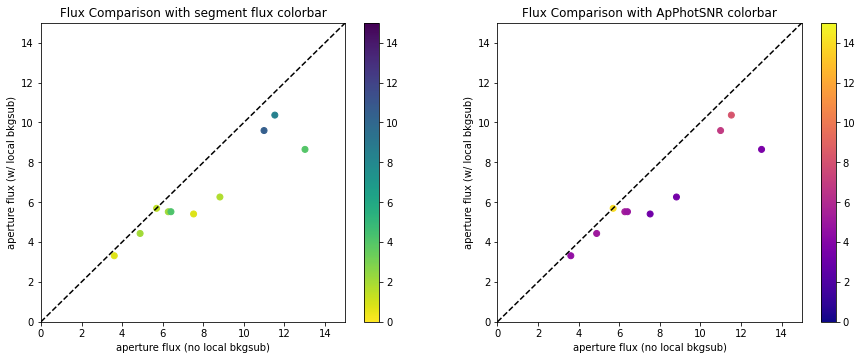

In [35]:
#a few diagnostic plots to examine background contributions to aperture flux
fig, (ax1,ax2) = plt.subplots(1, 2,figsize=(15,5.5))

ax1.set_title('Flux Comparison with segment flux colorbar')
p1=ax1.scatter(mtcut['aperture_sum_6as'],mtcut['aper_sum_bkgsub_6as'],c=mtcut['segment_flux'], cmap='viridis_r',vmin=0,vmax=15)
fig.colorbar(p1, ax=ax1)
ax1.plot([0,30],[0,30],'k--')
ax1.set_xlabel('aperture flux (no local bkgsub)')
ax1.set_ylabel('aperture flux (w/ local bkgsub)')
ax1.set_xlim(0,15)
ax1.set_ylim(0,15)

ax2.set_title('Flux Comparison with ApPhotSNR colorbar')
p2=ax2.scatter(mtcut['aperture_sum_6as'],mtcut['aper_sum_bkgsub_6as'],c=mtcut['aper_snr_6as'], cmap='plasma',vmin=0,vmax=15)
fig.colorbar(p2, ax=ax2)
ax2.plot([0,30],[0,30],'k--')
ax2.set_xlabel('aperture flux (no local bkgsub)')
ax2.set_ylabel('aperture flux (w/ local bkgsub)')
ax2.set_xlim(0,15)
ax2.set_ylim(0,15)


plt.show()

In [36]:
#write out the resulting table to file
ascii.write(mtcut, field+'_25um_cat_qcuts.dat', overwrite=True)